In [2]:
%%capture
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pickle 
import networkx as nx
from dataloader import *
from collections import deque, defaultdict
from tqdm import tqdm

In [3]:
with open("sub_graph.pkl", 'rb') as f:
    G = pickle.load(f)

In [13]:
with open("all_clusters_with_modularity.pkl", 'rb') as f:
    ac = pickle.load(f)

In [14]:
ac

[[[{'A', 'B', 'C', 'H'}, {'D', 'E', 'F', 'G'}], 0.5349999999999999],
 [[{'A', 'B', 'C'}, {'D', 'F'}, {'E'}, {'G'}, {'H'}], 0.23500000000000004],
 [[{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'}], 0.13999999999999996],
 [[{'A'}, {'B'}, {'C'}, {'D'}, {'E'}, {'F'}, {'G'}, {'H'}], 0.0]]

### Example graph B

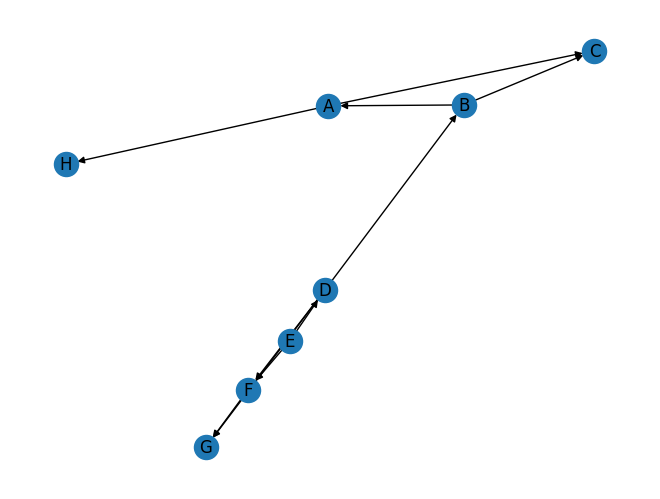

In [3]:

# Using example from the slides of the lecture
G_example = nx.DiGraph()

all_nodes = ['A','B','C','D','E','F','G','H']
G_example.add_nodes_from(all_nodes)

all_edges = [
    ('E','D'),('E','F'),
    ('F','G'),('D','G'),('D','B'),('B','A'),('B','C'),('A','H'),
    ('D','F'),('A','C')
]
G_example.add_edges_from(all_edges)
nx.draw(G_example, with_labels=True)


### Step 1: Betweenness centrality

In [5]:
## Optimized BFS
def bfs_shortest_paths(G, root):
    shortest_paths_dict = {root: [[root]]}
    queue = deque([(root, [root])])

    while queue:
        s, path = queue.popleft()

        for neighbor in G.neighbors(s):
            new_path = path + [neighbor]
            old_path = shortest_paths_dict.get(neighbor, [[None] * (len(new_path) + 1)])

            if len(new_path) == len(old_path[0]):
                shortest_paths_dict[neighbor].append(new_path)
            elif len(new_path) < len(old_path[0]):
                shortest_paths_dict[neighbor] = [new_path]
                queue.append((neighbor, new_path))

    return shortest_paths_dict

#lol = bfs_shortest_paths(G_example, 'E')

In [6]:
## Optimized edge betweenness centrality
def edge_betweenness_centrality(G):
    edge_betweenness = defaultdict(float)

    for node in G.nodes():
        shortest_paths_dict = bfs_shortest_paths(G, node)

        for paths in shortest_paths_dict.values():
            for path in paths:
                for i in range(len(path) - 1):
                    edge = (path[i], path[i + 1])
                    edge_betweenness[edge] += 1.0

    return edge_betweenness

#edge_betweenness = edge_betweenness_centrality(G_example)
#edge_betweenness

In [8]:
def girvan_newman_directed(G):
    G_copy = G.copy()
    communities = list(nx.weakly_connected_components(G_copy))
    results = {0: communities}
    
    step = 1
    
    while G_copy.number_of_edges() > 0:
        edge_betweenness = edge_betweenness_centrality(G_copy)
        max_betweenness = max(edge_betweenness.values())
        highest_betweenness_edges = [edge for edge, value in edge_betweenness.items() if value == max_betweenness]
        G_copy.remove_edges_from(highest_betweenness_edges)
        components = list(nx.weakly_connected_components(G_copy))
        results[step] = components
        step += 1
    
    return results


all_communities = girvan_newman_directed(G)

#for step, communities in all_communities.items():
#    print(f"{step}: {communities}")

In [9]:
def modularity(G, clusters_list):
    Q = 0
    m = len(list(G.edges()))
    for aCommunity in clusters_list:
        for v in list(aCommunity):
            for w in list(aCommunity):
                if v != w:
                    avw = 1 if (v,w) in list(G.edges()) or (w,v) in list(G.edges()) else 0               
                    new_term = avw - (G.degree(v)*G.degree(w))/(2*m)
                    Q += new_term
    return Q/(2*m)

In [11]:
def compute_modularity_for_all_communities(G, all_communities):
    result = []
    t = tqdm(total=len(list(all_communities.values())))
    for aCommunityRepartition in list(all_communities.values()):
        t.update()
        aModularity = modularity(G, aCommunityRepartition)
        result.append(
            [aCommunityRepartition, aModularity]
        )
    t.close()
    return result

In [12]:
all_clusters_with_modularity = compute_modularity_for_all_communities(G, all_communities)
all_clusters_with_modularity.sort(key= lambda x:x[1], reverse=True)
all_clusters_with_modularity[0]

KeyboardInterrupt: 

# Less optimized stuff

In [205]:
def bfs_shortest_paths(G, root):

    shortest_paths_dict = {root: [[root]]}
    queue = [(root, [root])]

    while queue:
        s, path = queue.pop(0)

        for neighbor in G.neighbors(s):
            
            if neighbor not in shortest_paths_dict:
                new_path = path + [neighbor]
                shortest_paths_dict[neighbor] = [new_path]
                queue.append((neighbor, new_path))
                
            elif len(path) + 1 == len(shortest_paths_dict[neighbor][0]):
                shortest_paths_dict[neighbor].append(path + [neighbor])

    return shortest_paths_dict

#lol = bfs_shortest_paths(G_example, 'E')
#lol


In [207]:
def edge_betweenness_centrality(G):
    
    edge_betweenness = {edge: 0.0 for edge in G.edges()}
    
    nodes = list(G.nodes())
    
    for node in nodes:
        shortest_paths_dict = bfs_shortest_paths(G, node)
        
        for source in shortest_paths_dict:
            for target_paths in shortest_paths_dict[source]:
                for i in range(len(target_paths) - 1):
                    edge = (target_paths[i], target_paths[i + 1])
                    edge_betweenness[edge] += 1.0
    
    return edge_betweenness

edge_betweenness = edge_betweenness_centrality(G_example)
edge_betweenness

{('A', 'H'): 4.0,
 ('A', 'C'): 1.0,
 ('B', 'A'): 6.0,
 ('B', 'C'): 3.0,
 ('D', 'G'): 2.0,
 ('D', 'B'): 8.0,
 ('D', 'F'): 1.0,
 ('E', 'D'): 6.0,
 ('E', 'F'): 2.0,
 ('F', 'G'): 2.0}